# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data
# Training and test data saved in the project root.
# The Jupyter notebook is run from the project root.
training_file = './train.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [4]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = [32, 32, 3]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = 43

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = [32, 32, 3]
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [5]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import numpy as np
import matplotlib.gridspec as gridspec

([<matplotlib.axis.XTick at 0x7fd92fd47ef0>,
 <a list of 22 Text xticklabel objects>)

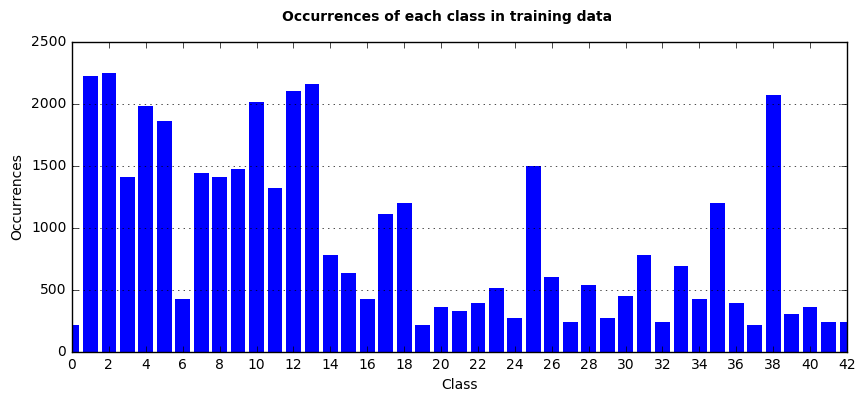

In [66]:
# count occurrences of each label in training data
# int16 is fine, since 2 ** 16 == 65535 > n_train == 39209
counts = np.zeros(n_classes, dtype=np.int16)
for label in y_train:
    counts[label] += 1
classes = np.arange(n_classes)

fig = plt.figure(1)
fig.suptitle('Occurrences of each class in training data', fontweight='bold')
fig.set_size_inches(10, 4)
ax = plt.gca()
ax.set_ylabel('Occurrences')
ax.set_xlabel('Class')
ax.yaxis.grid(True)
plt.bar(classes, counts, linewidth=0, align='center')
plt.xlim((0, 42))
plt.xticks(np.arange(0, n_classes, 2))

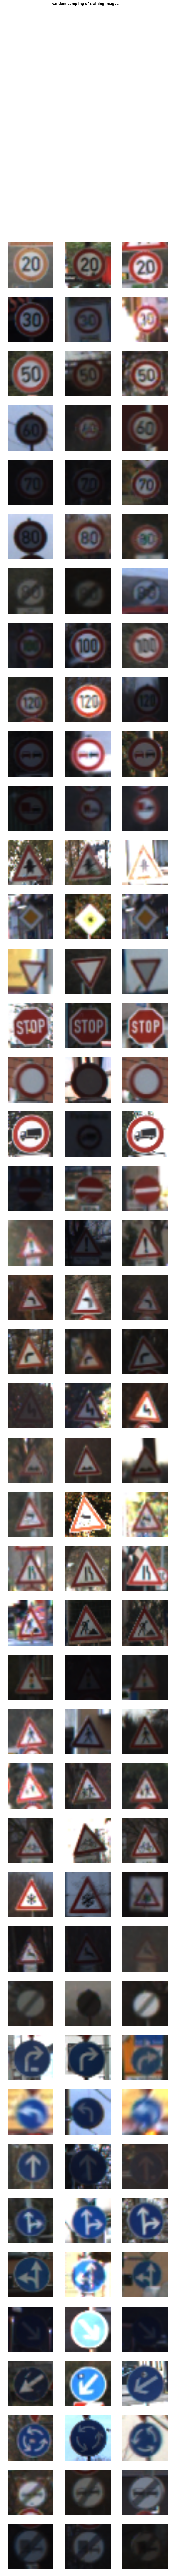

In [46]:
# get sample images to show
samples_per_class = 3
# initialize list of empty lists (which functions as a dict b/c classes are 0-indexed ints)
samples_by_class = [[] for i in range(n_classes)]
# loop over training images; pluck samples_per_class many of each class
# adjacent training images are very similar; shuffle to get a better random sampling
shuffled = np.arange(n_train)
np.random.shuffle(shuffled)
for i in shuffled:
    image = X_train[i]
    imclass = y_train[i]
    if len(samples_by_class[imclass]) < samples_per_class:
        samples_by_class[imclass].append(image)
# reduce samples mapping into single list
samples = []
for sample_group in samples_by_class:
    samples.extend(sample_group)

# show a sampling of train images
fig = plt.figure(2)
fig.suptitle('Random sampling of training images', fontweight='bold')
num_rows = n_classes
num_cols = samples_per_class
subplot_size_inches = 3
gs = gridspec.GridSpec(num_rows, num_cols)
fig.set_size_inches(subplot_size_inches * num_cols, subplot_size_inches * num_rows)
ax = [plt.subplot(gs[i]) for i in range(num_rows * num_cols)]
for i, image in enumerate(samples):
    ax[i].imshow(image)
    ax[i].axis('off')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [8]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
from sklearn.utils import shuffle

# normalize RGB values in input data
def normalize_images(image_data):
    return (image_data.astype(np.float32) - 128) / 128

X_train_normalized = normalize_images(X_train)
X_train_shuffled, y_train_shuffled = shuffle(X_train_normalized, y_train)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** I normalized the training data so RGB values range from -1 to 1, centered around 0 (i.e. -1 = 0, 128 = 0, 255 = 1). I normalized the data because it will be easier for the optimizer to train on data with zero mean and equal variance.

I also shuffled the data because I noticed the training data appears to be sequentially ordered by class. Shuffling ensures that each batch of training data contains a representative sample of all classes.

I deliberately did not convert the training data to grayscale because color contains meaning that should be captured by the model (e.g. red for stop signs, blue for turning signals).

In [9]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
import math

train_frac = .8
train_amount = math.floor(n_train * train_frac)

X_train_partial = X_train_shuffled[:train_amount]
X_validation = X_train_shuffled[train_amount:]

y_train_partial = y_train_shuffled[:train_amount]
y_validation = y_train_shuffled[train_amount:]

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** I saw no need to manipulate the test data in any way, since it was already provided separately from the training data.

However, I did split the provided training data into training data and validation data. This was necessary because we need validation data separate from the test data to verify that increases in accuracy of the training network apply to data it has not been trained on. I figured 80% of the original training data should actually be used for training and the remainder should be used for validation.

In [47]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten
    
# keep probability for dropout
# define outside function closures so we have access to it in both
keep_prob = tf.placeholder(tf.float32)

def TrafficSignClassifier(x):
    # Hyperparameters
    mu = 0
    sigma = 0.1

    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)
    # Dropout.
    conv1 = tf.nn.dropout(conv1, keep_prob)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** My final architecture largely unchanged from the LeCun architecture from the Convolutional Neural Networks lab. The biggest difference from the base LeCun architecture is the addition of dropout after the first convolution. Additionally, this architecture assumes RGB images rather than grayscale, so the initial input dimensions are changed from 32x32x1 to 32x32x3. I maintained the use of ReLU activation since it is linear and therefore fast on the GPU.

It consists of 5 layers: 2 convolutional layers followed by 3 fully connected layers. All layers are feed-forward only. All initial weights are random from a truncated normal distribution and all biases are initialized to 0. All convolution and pooling operations use valid padding.

Concise stats on each layer are as follows:

**Layer 1**<br>
Convolutional with a stride of 1, transforming from 32x32x3 to 28x28x6. Convolution is followed by ReLU activation, dropout, and max pooling with a stride of 2 transforming from 28x28x6 to 14x14x6.

**Layer 2**<br>
Convolutional with a stride of 1, transforming from 14x14x16 to 10x10x16. Convolution is followed by ReLU activation and max pooling with a stride of 2 transforming from 10x10x16 to 5x5x16. The 5x5x16 layer is then flattened to 400.

**Layer 3**<br>
Fully connected, transforming from 400 to 120, followed by ReLU activation.

**Layer 4**<br>
Fully connected, transforming from 120 to 84, followed by ReLU activation.

**Layer 5**<br>
Fully connected, transforming from 84 to 43. This output is the logits corresponding to the 43 different signs in the German traffic sign data set.

In [48]:
### Train your model here.
### Feel free to use as many code cells as needed.

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

In [49]:
# tune hyperparameters etc. here
learning_rate = 0.0005 # originally 0.001 in CNN lab
kp = 0.5 # keep probability for dropout
EPOCHS = 25 # originally 10 in CNN lab
BATCH_SIZE = 128

In [50]:
logits = TrafficSignClassifier(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_operation = optimizer.minimize(loss_operation)

# define for use later; might as well allow all variables to initialize at once
prediction_operation = tf.argmax(logits, 1)
softmax_operation = tf.nn.softmax(logits)

In [51]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={
            x: batch_x,
            y: batch_y,
            keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [52]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_partial)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_partial, y_train_partial = shuffle(X_train_partial, y_train_partial)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_partial[offset:end], y_train_partial[offset:end]
            sess.run(training_operation, feed_dict={
                x: batch_x,
                y: batch_y,
                keep_prob: kp})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, 'tsc')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.631

EPOCH 2 ...
Validation Accuracy = 0.823

EPOCH 3 ...
Validation Accuracy = 0.879

EPOCH 4 ...
Validation Accuracy = 0.902

EPOCH 5 ...
Validation Accuracy = 0.935

EPOCH 6 ...
Validation Accuracy = 0.949

EPOCH 7 ...
Validation Accuracy = 0.956

EPOCH 8 ...
Validation Accuracy = 0.959

EPOCH 9 ...
Validation Accuracy = 0.968

EPOCH 10 ...
Validation Accuracy = 0.967

EPOCH 11 ...
Validation Accuracy = 0.968

EPOCH 12 ...
Validation Accuracy = 0.977

EPOCH 13 ...
Validation Accuracy = 0.973

EPOCH 14 ...
Validation Accuracy = 0.979

EPOCH 15 ...
Validation Accuracy = 0.975

EPOCH 16 ...
Validation Accuracy = 0.975

EPOCH 17 ...
Validation Accuracy = 0.976

EPOCH 18 ...
Validation Accuracy = 0.983

EPOCH 19 ...
Validation Accuracy = 0.983

EPOCH 20 ...
Validation Accuracy = 0.982

EPOCH 21 ...
Validation Accuracy = 0.981

EPOCH 22 ...
Validation Accuracy = 0.979

EPOCH 23 ...
Validation Accuracy = 0.986

EPOCH 24 ...
Validation Accura

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** Some basic stats on how I trained the model are:

* Learning rate: 0.0005
* Keep probability (for dropout in training only): 0.5
* Epochs: 25
* Batch size: 128

I used the Adam optimizer to train the model; this was the default in the CNN lab and seemed to work well. From what I've read, Adam is a good improvement over plain gradient descent and uses a good mix of past gradient data and momentum: http://sebastianruder.com/optimizing-gradient-descent/index.html#adam

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:** I began by copying the LeNet architecture from the Convolutional Neural Net lab. This seemed like a good idea since that architecture was pretty good for training MNIST data and the traffic sign data is not significantly different conceptually. I did change the input channels from 1 to 3, since RGB data contains meaning that I wanted to capture in the model. I also changed the final output size to 43 to match the number of classes in the traffic sign dataset.

I then trained the model using the original parameters from the lab:

* Learning rate: 0.001
* Epochs: 10
* Batch size: 128

I found that this was pretty good, ending with a validation accuracy of around 0.975 &plusmn; 0.005, although I figured I could do better. I decided to add dropout to the first layer of the model with a keep probability of 0.5 to help avoid overfitting and increase model accuracy.

With the addition of dropout I noticed the model plateued much earlier than when I trained with the initial parameters. This made me decide to decrease the learning rate from 0.001 to 0.0005 and increase the epochs from 10 to 25, to allow the model to more slowly come to its final weights. I arrived at these values through trial and error.

The final result is a validation accuracy of 0.980 &plusmn; 0.005. I'm not sure if this is a statistically significant change or if it's due to chance, but the increase in accuracy seemed to be consistent after training the model a few times.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [53]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
new_images_paths = [
    './new_images/general_caution.png',
    './new_images/no_entry.png',
    './new_images/speed_limit_30.png',
    './new_images/keep_right.png',
    './new_images/turn_right_ahead.png'
]
new_images_names = [
    'General Caution',
    'No Entry',
    'Speed limit (30km/h)',
    'Keep Right',
    'Turn Right Ahead'
]
y_new_images = [
    18, # General Caution,
    17, # No Entry
    1,  # Speed Limit 30km/h
    38, # Keep Right
    33  # Turn Right Ahead
]

# The PNG images I've created load in as floats
# valued [0, 1]. Convert to scale [-1, 1].
def normalize_custom_images(image_data):
    return (image_data * 2) - 1

X_new_images = np.zeros((len(new_images_paths), 32, 32, 3))
for i, path in enumerate(new_images_paths):
    im = plt.imread(path, format='png')
    X_new_images[i] = im
X_new_images_testable = normalize_custom_images(X_new_images)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:** My images shouldn't be hard to classify, since they are all fairly clean and mostly centered. The "no entry" sign is offset slightly upwards and has a red circle beneath it, which may cause problems. Additionally, the "speed limit 30" and "turn right" ahead signs are more like ovals rather than circles, which may cause problems if the circular signs in the training data are actually circular. In general, my images also seem brighter than many of the images in the training data, which appear to be dark and blurry; the classifier may understand darkness as a signal.

#### Image Credits

All images were created from screenshots I took from Google Maps Street View. The following signs were from the following addresses:

Glinkastraße 23<br>
Berlin, Germany<br>
https://www.google.com/maps/@52.5136642,13.3863335,3a,75y,349.15h,84.59t/data=!3m6!1e1!3m4!1sj5dgGZxABfEGtold1HGBBg!2e0!7i13312!8i6656
* General caution
* No entry
* Speed limit (30km/h)

Friedrichstraße 194<br>
Berlin, Germany<br>
https://www.google.com/maps/place/Friedrichstra%C3%9Fe+194,+10117+Berlin,+Germany/@52.5099704,13.3875606,17z/data=!3m1!4b1!4m5!3m4!1s0x47a851d056263b49:0x376c38237a17648f!8m2!3d52.5099704!4d13.3897493
* Keep right

Kronenstraße 1<br>
Berlin, Germany<br>
https://www.google.com/maps/@52.5110638,13.3870911,3a,75y,290.47h,81.81t/data=!3m6!1e1!3m4!1soAs_OpfR3yoJsUwwr2bk4g!2e0!7i13312!8i6656
* Turn right ahead

Test Data Accuracy = 0.918
Predictions for new images: [18 17  1 38 33]
             Actual values: [18, 17, 1, 38, 33]


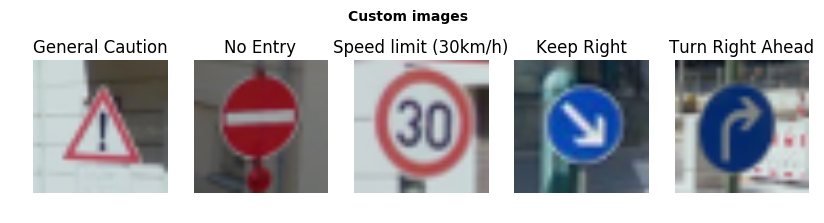

In [79]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

new_image_predictions = None
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    new_image_predictions = sess.run(prediction_operation, feed_dict={
        x: X_new_images_testable,
        keep_prob: 1.0 })
    # run the test data too, for comparison with my own images
    X_test_normalized = normalize_images(X_test)
    test_data_accuracy = evaluate(X_test_normalized, y_test)
    print("Test Data Accuracy = {:.3f}".format(test_data_accuracy))

print("Predictions for new images:", new_image_predictions)
print("             Actual values:", y_new_images)

fig = plt.figure(3)
fig.suptitle('Custom images', fontweight='bold')
fig.set_size_inches(10, 2.5)
for i, im in enumerate(X_new_images):
    subplot = '1' + str(len(X_new_images)) + str(i + 1)
    ax = fig.add_subplot(subplot)
    ax.imshow(im)
    ax.set_title(new_images_names[i])
    plt.axis('off')

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:** According to the results above, my model is 100% accurate. However, on past runs I have seen accuracies of 60% and 80%. Although encouraging, the "new image" dataset is too small to draw proper comparison with the result of testing the model on the test data, which drew an accuracy of 91.8%, which is notably smaller than the accuracy of the model against the training data (98.7%).

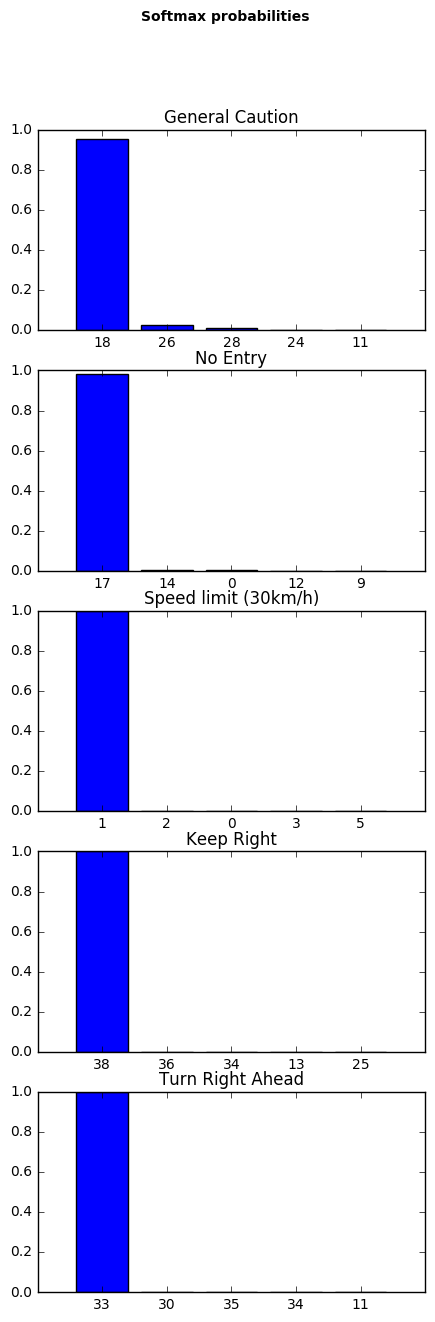

In [77]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

new_images_softmax_top_k = None
k = 5
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    new_images_softmax = sess.run(softmax_operation, feed_dict={
        x: X_new_images_testable,
        keep_prob: 1.0 })
    new_images_softmax_top_k = sess.run(tf.nn.top_k(tf.constant(new_images_softmax), k=5))

softmax_top_k_values = new_images_softmax_top_k.values
softmax_top_k_indices = new_images_softmax_top_k.indices
fig = plt.figure(4)
fig.suptitle('Softmax probabilities', fontweight='bold')
fig.set_size_inches(5, 15)
new_images_count = len(new_images_names)
for i in range(new_images_count):
    subplot = str(new_images_count) + '1' + str(i + 1)
    ax = fig.add_subplot(subplot)
    ax.set_title(new_images_names[i])
    plt.bar(range(k), softmax_top_k_values[i], align='center')
    plt.xticks(range(k), softmax_top_k_indices[i])

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:** Based on the plots above, my model is highly certain of all the new image predictions. The least certain prediction is for the "general caution" sign. Given the 91.8% accuracy of the test data, I think these accuracies are pretty good.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.